# Data Augmentation With Geometric Transformations

### Learning Objectives

You will learn how to apply data augmentation in two ways:

* Use Preprocessors.

* Use geometric transformation for augmenting the data.

## Introduction

Creating training datasets for machine learning is the first step of the standard image processing pipeline. The next stage is preprocessing the raw images in order to feed them to the model for training or inference. Before raw images can be fed into an image model, they usually have to be preprocessed. Such preprocessing has several, overlapping goals: shape transformation, data quality, and model quality. 

In this notebook, you learn how to set up preprocessing to ensure reproducibility in production, and then delve into ways to implement a variety of preprocessing operations in Keras/TensorFlow. In this notebook, you also learn how to carry out data augmentation to improve the model's resilience and accuracy. Data augmentation can be effectively used to train the deep learning models. Some of the simple transformations applied to the image are; geometric transformations such as Flipping, Rotation, Translation, Cropping and Scaling.

Each learning objective will correspond to a __#TODO__ in the notebook where you will complete the notebook cell's code before running. Refer to the [solution](../solutions/data_augmentation_with_geometric_transformations.ipynb) for reference.

In [2]:
!pip install --upgrade tensorflow-estimator==2.6.0

     |████████████████████████████████| 462 kB 8.9 MB/s            
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.18.0 requires tensorflow-io-gcs-filesystem==0.18.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tensorflow 2.6.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.0 requires tensorboard~=2.6, but you have tensorboard 2.5.0 which is incompatible.
tensorflow 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
tensorflow 2.6.0 requires wrapt~=1.12.1, but you have wrapt 1.13.3 which is incomp

Please ignore any incompatibility warnings and errors and re-run the cell to view the installed tensorflow version.

In [3]:
# Import and print the installed version of TensorFlow
import tensorflow as tf
print(tf.version.VERSION)

2.6.0


## Mixing Keras and TensorFlow
A center cropping function is available in TensorFlow, but to keep things interesting, let’s mix the TensorFlow resize_with_pad and Keras’ CenterCrop functionality.

In order to call an arbitrary set of TensorFlow functions as part of a Keras model, wrap the function(s) inside a Keras Lambda layer. because we want to do the resize and follow it by a center crop, our preprocessing layers become preproc_layers.

Note that the very first layer within the Sequential carries an input_shape parameter. Because the input images will be of different sizes, we specify the height and width as None, which leaves the values to be determined at runtime, but do specify that there will always be 3 channels.

#### Defining Helper Functions

In [4]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

## Preprocessor
This class contains preprocessing functions that have to be explicitly applied between training and prediction.

In [5]:
# The import statement combines two operations; it searches for the named module, then it binds the results of that search
# to a name in the local scope.
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

IMG_HEIGHT = 448 # note *twice* what we used to have
IMG_WIDTH = 448
IMG_CHANNELS = 3
CLASS_NAMES = 'daisy dandelion roses sunflowers tulips'.split()

class _Preprocessor:    
    def __init__(self):
        # nothing to initialize
        pass
    
    def read_from_tfr(self, proto):
        feature_description = {
            'image': tf.io.VarLenFeature(tf.float32),
            'shape': tf.io.VarLenFeature(tf.int64),
            'label': tf.io.FixedLenFeature([], tf.string, default_value=''),
            'label_int': tf.io.FixedLenFeature([], tf.int64, default_value=0),
        }
        rec = tf.io.parse_single_example(
            proto, feature_description
        )
        shape = tf.sparse.to_dense(rec['shape'])
        img = tf.reshape(tf.sparse.to_dense(rec['image']), shape)
        label_int = rec['label_int']
        return img, label_int
    
    def read_from_jpegfile(self, filename):
        # same code as in 05_create_dataset/jpeg_to_tfrecord.py
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
      
    def preprocess(self, img):
        #TODO 1: Resize and pad the image to a target width and height.
        return tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH)
    
def create_preproc_dataset(pattern):
    preproc = _Preprocessor()
    trainds = tf.data.TFRecordDataset(
        [filename for filename in tf.io.gfile.glob(pattern)],
        compression_type='GZIP'
    ).map(preproc.read_from_tfr).map(
        lambda img, label: (preproc.preprocess(img), label))                             
    return trainds

def create_preproc_image(filename):
    preproc = _Preprocessor()
    img = preproc.read_from_jpegfile(filename)
    return preproc.preprocess(img)    

## Reading TF Records
To read TensorFlow records, use a tf.data.TFRecordDataset. To read all the training files into a TensorFlow dataset, we can pattern match and then pass the resulting files into TFRecordDataset:

`train_dataset = tf.data.TFRecordDataset(tf.data.Dataset.list_files('gs://tfr_dataset_path/train-*'))`

The dataset at this point contains protobufs. We need to parse the protobufs based on the schema of the records that we wrote to the files. We specify that schema by using feature_description. The label and label_int have fixed length (1), but the image and its shape are variable length (since they are arrays).

Given the proto and the feature description (or schema), we can read in the data using the function parse_single_example:
rec = tf.io.parse_single_example(proto, feature_description)
For storage efficiency, variable length arrays are stored as SparseTensors (see sidebar). We can make them dense and reshape the flattened image array into a 3D tensor, giving us the full parsing function: read_from_tfr(self, proto). 
We can now apply the above parsing function to every proto that is read using map():

`train_dataset = tf.data.TFRecordDataset(
    [filename for filename in tf.io.gfile.glob(
        'gs://practical-ml-vision-book/flowers_tfr/train-*')
    ]).map(parse_tfr)`

At this point, the training dataset gives us the image and its label that we can use just like the image and label we obtained from the CSV dataset

2021-11-17 12:59:45.773244: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2021-11-17 12:59:45.980046: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(240, 320, 3)
tf.Tensor(0.3526376, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(213, 320, 3)
tf.Tensor(0.69847906, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(240, 320, 3)
tf.Tensor(0.22729625, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(333, 500, 3)
tf.Tensor(0.27678293, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(240, 320, 3)
tf.Tensor(0.39305466, shape=(), dtype=float32)
tf.Tensor(1, shape=(), dtype=int64)


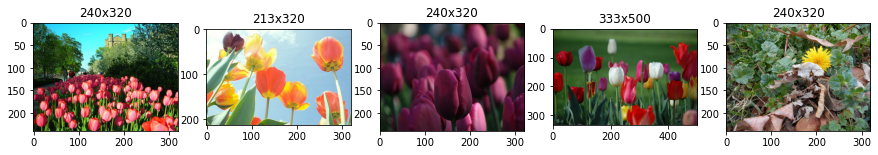

In [6]:
def parse_tfr(proto):
    feature_description = {
        'image': tf.io.VarLenFeature(tf.float32),
        'shape': tf.io.VarLenFeature(tf.int64),
        'label': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'label_int': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    }
    rec = tf.io.parse_single_example(
        proto, feature_description
    )
    shape = tf.sparse.to_dense(rec['shape'])
    img = tf.reshape(tf.sparse.to_dense(rec['image']), shape)
    label_int = rec['label_int']
    return img, label_int

train_dataset = tf.data.TFRecordDataset(
    [filename for filename in tf.io.gfile.glob(
        'gs://practical-ml-vision-book/flowers_tfr/train-*')
    ], compression_type='GZIP').map(parse_tfr)

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(train_dataset.take(5)):
    print(img.shape)
    mean_of_image = tf.reduce_mean(img)
    print(mean_of_image)
    print(label_int)
    ax[idx].imshow((img.numpy()));
    ax[idx].set_title('{}x{}'.format(img.shape[0], img.shape[1]))

## Resizing and other preprocessing layers
One of the key reasons to preprocess images is to ensure that the image tensors have the shape expected by the Input layer of the ML model. In order to do so, we usually have to change the size and/or resolution of the images being read in.
#### Keras Preprocessing Layer
We have to preprocess the differently sized images to the shape expected by the Input layer of the ML model. Keras has a preprocessing layer that offers resizing all the images to our desired height and width. So, we can create a Sequential model that contains all our preprocessing operations by using resizing(). To apply the preprocessing layer to our image, we could do:
`train_dataset.map(lambda img: preproc_layers(img))`
However, this won’t work because the train_dataset provides a tuple (img, label) where the image is a 3D tensor (height, width, channels) while the Keras Sequential model expects a 4D tensor (batchsize, height, width, channels).

The simplest solution is to write a function that adds an extra dimension to the image at the first axis using expand_dims() and removes the batch dimension from the result using squeeze(). We are doing this in apply_preproc(img, label).

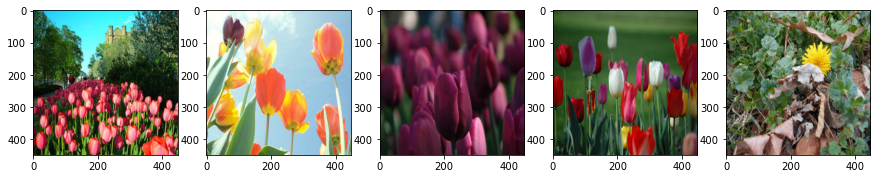

In [7]:
preproc_layers = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(
        height=IMG_HEIGHT, width=IMG_WIDTH,
        input_shape=(None, None, 3))
    ])

def apply_preproc(img, label):
    # add to a batch, call preproc, remove from batch
    x = tf.expand_dims(img, 0)
    x = preproc_layers(x)
    x = tf.squeeze(x, 0)
    return x, label

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(train_dataset.map(apply_preproc).take(5)):
    ax[idx].imshow((img.numpy()));

## TensorFlow Image Module
In addition to the resize() function that we used in Chapter 2, TensorFlow offers a plethora of image processing functions in the [tf.image module](https://www.tensorflow.org/api_docs/python/tf/image). We have used decode_jpeg from this module, but TensorFlow also has the ability to decode PNG, GIF, and BMP and to convert images between color and grayscale. There are methods to work with bounding boxes, to adjust contrast, brightness, and so on.

In the realm of resizing, TensorFlow allows us to retain the aspect ratio when resizing by cropping the image to the desired aspect ratio and stretching it:

img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH],
                      preserve_aspect_ratio=True)
or padding the edges with zeros:
img = tf.image.resize_with_pad(img, [IMG_HEIGHT, IMG_WIDTH])

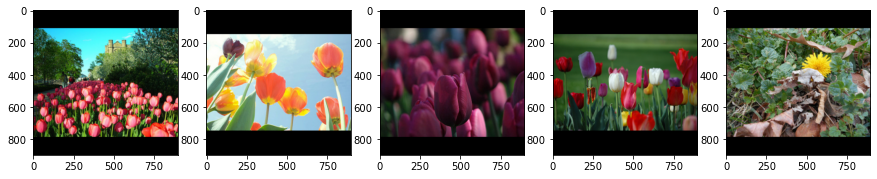

In [8]:
def apply_preproc(img, label):
    return tf.image.resize_with_pad(img, 2*IMG_HEIGHT, 2*IMG_WIDTH), label

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(train_dataset.map(apply_preproc).take(5)):
    ax[idx].imshow((img.numpy()));

## Data augmentation

Preprocessing is useful beyond simply reformatting images to the size and shape required by the model. Preprocessing can also be a way to improve model quality through data augmentation.

Data augmentation is a data-space solution to the problem of insufficient data (or insufficient data of the right kind) – it is a set of techniques that enhance the size and quality of training datasets with the goal of creating machine learning models that are more accurate and that generalize better.

Keras [supports](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/) several data augmentation layers, including RandomTranslation, RandomRotation, RandomZoom, RandomCrop, RandomFlip, and so on. They all work similarly.

The RandomFlip layer will, during training time, randomly flip the image or keep it in its original orientation. During inference, the image is passed through unchanged. Keras does this automatically – all that we have to do is to add as one of the layers in our model.

Any preprocessing code that we put into the Keras model will be automatically applied during prediction. Therefore, let’s take the center cropping functionality out of the Preprocessor class and move it into the model itself. 

Note that the first layer of a Sequential layer is the one that carries the input_shape parameter. So, we have removed the input_shape from the Hub layer and put it on the CenterCrop. The input to the CenterCrop is twice the desired size of the images, so that’s what we specify.

When we do a center crop, we lose a considerable part of the image. To improve our training performance, we could consider augmenting the data by taking random crops of the desired size from the input image. The RandomCrop layer in Keras will do random crops during training (so that the model sees different parts of the image during each epoch, although some of them will now include the padded edges and may not even include the flowers that are of interest) and behave like a CenterCrop during inference.

Training this model is similar to training without augmentation. However, we will need to train the model longer whenever we augment data. Intuitively, we need to train for twice as many epochs in order for the model to see both flips of the image.


In [9]:
import tensorflow_hub as hub
import os
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'    

#PATTERN_SUFFIX='-0000*'
#NUM_EPOCHS=3

PATTERN_SUFFIX='-*'
NUM_EPOCHS=20

# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)
    
    train_dataset = create_preproc_dataset(
        'gs://practical-ml-vision-book/flowers_tfr/train' + PATTERN_SUFFIX
    ).batch(batch_size)
    eval_dataset = create_preproc_dataset(
        'gs://practical-ml-vision-book/flowers_tfr/valid' + PATTERN_SUFFIX
    ).batch(batch_size)

    layers = [
      tf.keras.layers.experimental.preprocessing.RandomCrop(
          height=IMG_HEIGHT//2, width=IMG_WIDTH//2,
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          name='random/center_crop'
      ),
      tf.keras.layers.experimental.preprocessing.RandomFlip(
          mode='horizontal',
          name='random_lr_flip/none'
      ),
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation=tf.keras.activations.relu,
                            name='dense_hidden'),
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
    ]
    
    # TODO 2: Define Sequential model
    model = tf.keras.Sequential(layers, name='flower_classification')
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=NUM_EPOCHS)
    training_plot(['loss', 'accuracy'], history)
    return model

Model: "flower_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random/center_crop (RandomCr (None, 224, 224, 3)       0         
_________________________________________________________________
random_lr_flip/none (RandomF (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_embedding (KerasLa (None, 1280)              2257984   
_________________________________________________________________
dense_hidden (Dense)         (None, 16)                20496     
_________________________________________________________________
flower_prob (Dense)          (None, 5)                 85        
Total params: 2,278,565
Trainable params: 20,581
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/20
92/92 [==============================] - 68s 686ms/step - loss: 0.8662 - accurac

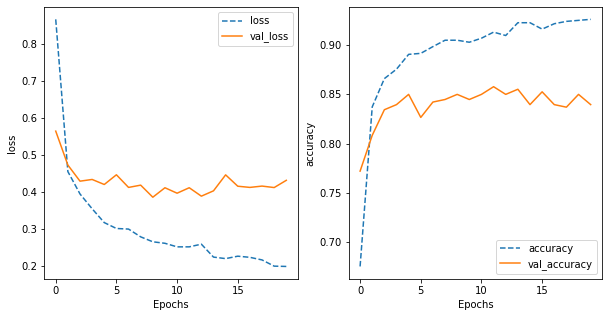

In [10]:
model = train_and_evaluate()

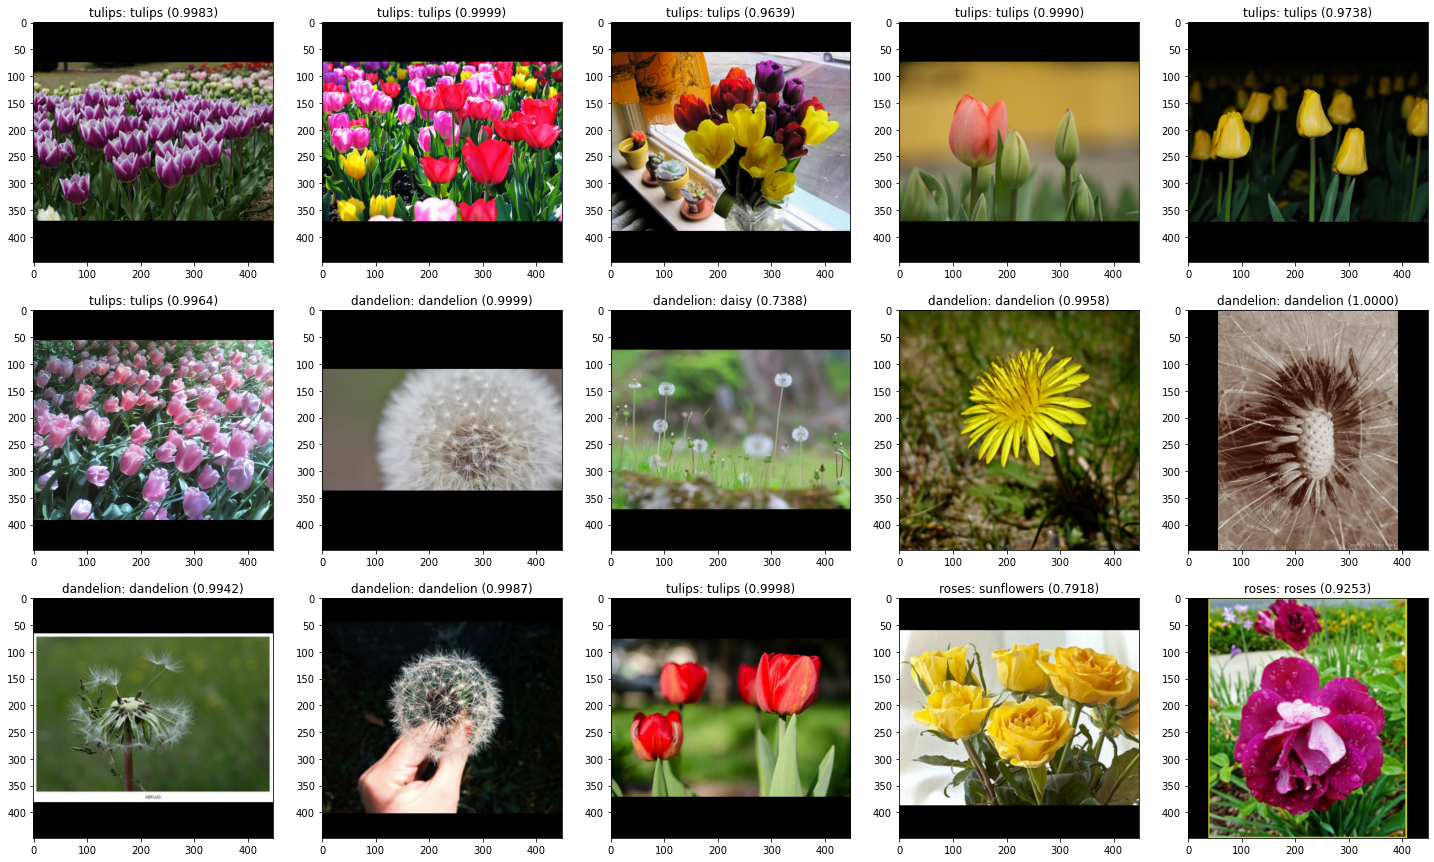

In [11]:
# Call model.predict() on a few images in evaluation dataset
def plot_predictions(model, pattern):
    dataset = create_preproc_dataset(pattern)
    f, ax = plt.subplots(3, 5, figsize=(25,15))
    for idx, (img, label) in enumerate(dataset.take(15)):
        ax[idx//5, idx%5].imshow((img.numpy()));
        batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
        batch_pred = model.predict(batch_image)
        pred = batch_pred[0]
        label = CLASS_NAMES[label.numpy()]
        pred_label_index = tf.math.argmax(pred).numpy()
        pred_label = CLASS_NAMES[pred_label_index]
        prob = pred[pred_label_index]
        ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

plot_predictions(model, 'gs://practical-ml-vision-book/flowers_tfr/valid-*')

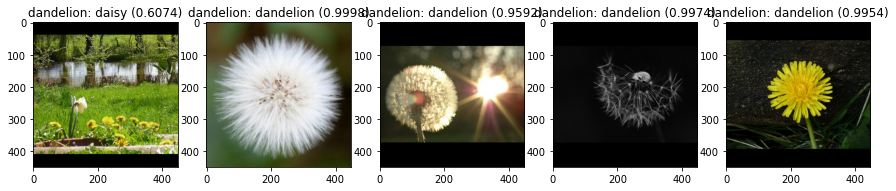

In [12]:
## but actually, for prediction, you won't have TensorFlow Records.
## this is how you'd predict for individual images
filenames = [
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/98992760_53ed1d26a9.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9939430464_5f5861ebab.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9965757055_ff01b5ee6f_n.jpg'
]
label = 'dandelion'
input_images = [create_preproc_image(f) for f in filenames]
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, img in enumerate(input_images):
    ax[idx].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))